In [11]:
import argparse
import os
import torch
import torch.backends.cudnn as cudnn

from network.TorchUtils import TorchModel
from features_loader import FeaturesLoaderVal, FeaturesLoader, FeaturesLoaderTrain
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from os import path
import numpy as np
from scipy import spatial

def get_centroids(model, data_iter, verbose):
    
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")
    
    normal_embed = None
    anomaly_embed = None
    
    n_normal = 0
    n_anomaly = 0

    with torch.no_grad():
        if verbose:
            data_gen = tqdm(data_iter)
        else:
            data_gen = data_iter
        for features, labels in tqdm(data_iter):
            # features is a batch where each item is a tensor of 32 4096D features
            features = features.to(device)
            labels = labels#.squeeze()
            
            outputs = model(features)  # (batch_size, 32, embed_size)
        
            embed = outputs.mean(1).cpu().numpy()
            y_true = labels.cpu().numpy()
            
            if (y_true == 0).sum():
                if normal_embed is None and (y_true == 0).sum():
                    normal_embed = embed[y_true == 0].mean(0)
                else:
                    normal_embed += embed[y_true == 0].mean(0)
                
            if (y_true == 1).sum():
                if anomaly_embed is None:
                    anomaly_embed = embed[y_true == 1].mean(0)
                else:
                    anomaly_embed += embed[y_true == 1].mean(0)

            n_normal += (y_true == 0).sum()
            n_anomaly += (y_true == 1).sum()
            
            torch.cuda.empty_cache()

    centroids = np.array([normal_embed/n_normal, anomaly_embed/n_anomaly]) 
    return centroids
    

def compute_roc_auc(features_path, annotation_path, train_features_path, train_annotation_path,
                    model_path, calc_mode, filename = '', verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")

    data_loader = FeaturesLoaderVal(features_path=features_path,
                                    annotation_path=annotation_path)

    data_iter = torch.utils.data.DataLoader(data_loader,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=0,  # 4, # change this part accordingly
                                            pin_memory=True)
    
    
    train_data_loader = FeaturesLoaderTrain(features_path=train_features_path,
                                            annotation_path=train_annotation_path)

    train_data_iter = torch.utils.data.DataLoader(train_data_loader,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=0,  # 4, # change this part accordingly
                                            pin_memory=True)

    model = TorchModel.load_model(model_path).to(device).eval()

    # enable cudnn tune
    cudnn.benchmark = True


    y_trues = torch.tensor([])
    y_preds = torch.tensor([])
    
    if calc_mode == 'triplet_centroid':
        centroids = get_centroids(model, train_data_iter, verbose)

    with torch.no_grad():
        if verbose:
            data_gen = tqdm(data_iter)
        else:
            data_gen = data_iter
        for features, start_end_couples, lengths in data_gen:
            # features is a batch where each item is a tensor of 32 4096D features
            features = features.to(device)
            if calc_mode == 'mil':
                outputs = model(features).squeeze(-1)  # (batch_size, 32)
            else: # in case of Triplet loss
                outputs = model(features)  # (batch_size, 32, embed_size)
            for vid_len, couples, output in zip(lengths, start_end_couples, outputs.cpu().numpy()):
                y_true = np.zeros(vid_len)
                y_pred = np.zeros(vid_len)

                segments_len = vid_len // 32
                for couple in couples:
                    if couple[0] != -1:
                        y_true[couple[0]: couple[1]] = 1

                for i in range(32):
                    segment_start_frame = i * segments_len
                    segment_end_frame = (i + 1) * segments_len
                    if calc_mode == 'triplet_centroid':
                        y_pred[segment_start_frame: segment_end_frame] = ((output[i] - centroids[0])**2).sum(-1)
                    elif calc_mode == 'triplet':
                        y_pred[segment_start_frame: segment_end_frame] = ((output[i] - output[0])**2).sum(-1)
                    else: # default MIL calculation
                        y_pred[segment_start_frame: segment_end_frame] = output[i]

                if y_trues is None:
                    y_trues = y_true
                    y_preds = y_pred
                else:
                    y_trues = np.concatenate([y_trues, y_true])
                    y_preds = np.concatenate([y_preds, y_pred])

    fpr, tpr, thresholds = roc_curve(y_true=y_trues, y_score=y_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    if verbose:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        if len(filename):
            os.makedirs('graphs', exist_ok=True)
            plt.savefig(path.join('graphs', filename))
            plt.close()
            print('ROC curve (area = %0.3f)' % roc_auc)
        else:
            plt.show()
            print('ROC curve (area = %0.3f)' % roc_auc)
    return roc_auc

In [12]:
features_path = './data/anomaly_features'
annotation_path = "Test_Annotation.txt"
model_path = "exps/grid_search/triplet_adadelta_0.1_8e-05_3_5_0.2/42/models/epoch_19.pt"
calc_mode = "triplet_centroid"
train_features_path = 'data/anomaly_features'
train_annotation_path = "Train_Annotation.txt"
filename = "roc_auc.png"

100%|██████████| 290/290 [00:54<00:00,  5.31it/s]


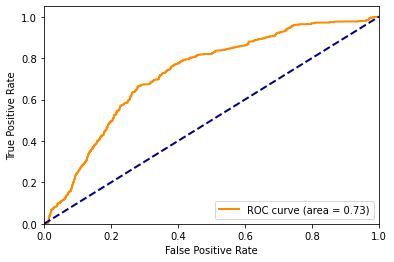

ROC curve (area = 0.725)


0.7250870223224508

In [3]:
compute_roc_auc(features_path, annotation_path, train_features_path, train_annotation_path,
                model_path, calc_mode)

In [1]:
import pandas as pd

res_df_triplet = pd.read_csv('../res_df_triplet.csv', header=0, index_col=0).reset_index(drop=True)

In [42]:
for col in res_df_triplet.columns[2:]:
    print(res_df_triplet[[col]].max())

roc_auc_epoch_0    0.706±0.000
dtype: object
roc_auc_epoch_1    0.707±0.000
dtype: object
roc_auc_epoch_2    0.705±0.000
dtype: object
roc_auc_epoch_3    0.707±0.000
dtype: object
roc_auc_epoch_4    0.705±0.000
dtype: object
roc_auc_epoch_5    0.709±0.000
dtype: object
roc_auc_epoch_6    0.706±0.000
dtype: object
roc_auc_epoch_7    0.715±0.000
dtype: object
roc_auc_epoch_8    0.706±0.000
dtype: object
roc_auc_epoch_9    0.709±0.000
dtype: object


In [43]:
res_df_triplet[res_df_triplet['roc_auc_epoch_7'] == '0.715±0.000']

,params,calc_mode,roc_auc_epoch_0,roc_auc_epoch_1,roc_auc_epoch_2,roc_auc_epoch_3,roc_auc_epoch_4,roc_auc_epoch_5,roc_auc_epoch_6,roc_auc_epoch_7,roc_auc_epoch_8,roc_auc_epoch_9
32,triplet_adam_0.5_8e-05_3_3_0.02,triplet,0.691±0.000,0.554±0.000,0.665±0.000,0.628±0.000,0.571±0.000,0.574±0.000,0.634±0.000,0.715±0.000,0.618±0.000,0.655±0.000


In [2]:
res_df_triplet_centroid = pd.read_csv('../res_df_triplet_centroid.csv', header=0, index_col=0).reset_index(drop=True)

In [45]:
for col in res_df_triplet_centroid.columns[2:]:
    print(res_df_triplet_centroid[[col]].max())

roc_auc_epoch_0    0.715±0.000
dtype: object
roc_auc_epoch_1    0.724±0.000
dtype: object
roc_auc_epoch_2    0.715±0.000
dtype: object
roc_auc_epoch_3    0.707±0.000
dtype: object
roc_auc_epoch_4    0.725±0.000
dtype: object
roc_auc_epoch_5    0.708±0.000
dtype: object
roc_auc_epoch_6    0.710±0.000
dtype: object
roc_auc_epoch_7    0.718±0.000
dtype: object
roc_auc_epoch_8    0.712±0.000
dtype: object
roc_auc_epoch_9    0.717±0.000
dtype: object


In [46]:
res_df_triplet_centroid[res_df_triplet_centroid['roc_auc_epoch_4'] == '0.725±0.000']

,params,calc_mode,roc_auc_epoch_0,roc_auc_epoch_1,roc_auc_epoch_2,roc_auc_epoch_3,roc_auc_epoch_4,roc_auc_epoch_5,roc_auc_epoch_6,roc_auc_epoch_7,roc_auc_epoch_8,roc_auc_epoch_9
1,triplet_adadelta_0.1_8e-05_3_3_0.02,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
3,triplet_adadelta_0.1_8e-05_3_3_0.2,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
5,triplet_adadelta_0.1_8e-05_3_5_0.02,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
7,triplet_adadelta_0.1_8e-05_3_5_0.2,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
9,triplet_adadelta_0.1_8e-05_5_3_0.02,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
11,triplet_adadelta_0.1_8e-05_5_3_0.2,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
13,triplet_adadelta_0.1_8e-05_5_5_0.02,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000
15,triplet_adadelta_0.1_8e-05_5_5_0.2,triplet_centroid,0.715±0.000,0.721±0.000,0.711±0.000,0.707±0.000,0.725±0.000,0.708±0.000,0.710±0.000,0.718±0.000,0.712±0.000,0.717±0.000


In [47]:
res_df_triplet_centroid[res_df_triplet_centroid['roc_auc_epoch_1'] == '0.724±0.000']

,params,calc_mode,roc_auc_epoch_0,roc_auc_epoch_1,roc_auc_epoch_2,roc_auc_epoch_3,roc_auc_epoch_4,roc_auc_epoch_5,roc_auc_epoch_6,roc_auc_epoch_7,roc_auc_epoch_8,roc_auc_epoch_9
33,triplet_adadelta_0.5_8e-05_3_3_0.02,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
35,triplet_adadelta_0.5_8e-05_3_3_0.2,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
37,triplet_adadelta_0.5_8e-05_3_5_0.02,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
39,triplet_adadelta_0.5_8e-05_3_5_0.2,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
41,triplet_adadelta_0.5_8e-05_5_3_0.02,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
43,triplet_adadelta_0.5_8e-05_5_3_0.2,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
45,triplet_adadelta_0.5_8e-05_5_5_0.02,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000
47,triplet_adadelta_0.5_8e-05_5_5_0.2,triplet_centroid,0.712±0.000,0.724±0.000,0.709±0.000,0.706±0.000,0.718±0.000,0.701±0.000,0.699±0.000,0.715±0.000,0.709±0.000,0.710±0.000


In [79]:
def row_max(x):
    return np.max([float(y.split('±')[0]) for y in x.values[2:]])

idx = res_df_triplet.agg(row_sum, axis='columns').argsort()[-5:].values
res_df_triplet_final = res_df_triplet.iloc[idx]

In [80]:
idx2 = res_df_triplet_centroid.agg(row_sum, axis='columns').argsort()[-10:].values
res_df_triplet_centroid_final = res_df_triplet_centroid.iloc[idx2]

In [122]:
dfs = []
for row in res_df_triplet_final.iterrows():
    params = row[1]['params']
    epoch = row[1][2:][row[1][2:] == row[1][2:].max()].keys()[0].split('_')[-1]
    df = pd.DataFrame({'loss_func': ['triplet loss'],
                       'inference mode': ['base'],
                       'optimizer': [params.split('_')[1]],
                       'dropout rate': [params.split('_')[2]],
                       'lambdas': [params.split('_')[3]],
                       'n_anomaly_segments': [params.split('_')[4]],
                       'n_normal_segments': [params.split('_')[5]],
                       'margin': [params.split('_')[6]],
                       'best epoch': [epoch],
                       'best roc-auc': [row[1][2:].max()],})
    dfs.append(df)
    
res_df_triplet_centroid_final = res_df_triplet_centroid_final.loc[[33,47,3,1,13]]

for row in res_df_triplet_centroid_final.iterrows():
    params = row[1]['params']
    epoch = row[1][2:][row[1][2:] == row[1][2:].max()].keys()[0].split('_')[-1]
    df = pd.DataFrame({'loss_func': ['triplet loss'],
                       'inference mode': ['centroid'],
                       'optimizer': [params.split('_')[1]],
                       'dropout rate': [params.split('_')[2]],
                       'lambdas': [params.split('_')[3]],
                       'n_anomaly_segments': [params.split('_')[4]],
                       'n_normal_segments': [params.split('_')[5]],
                       'margin': [params.split('_')[6]],
                       'best epoch': [epoch],
                       'best roc-auc': [row[1][2:].max()],})
    dfs.append(df)

In [123]:
final_res = pd.concat(dfs).reset_index(drop=True)
final_res

,loss_func,inference mode,optimizer,dropout rate,lambdas,n_anomaly_segments,n_normal_segments,margin,best epoch,best roc-auc
0,triplet loss,base,adam,0.1,0.008,5,5,0.2,3,0.707±0.000
1,triplet loss,base,adam,0.1,8e-05,3,3,0.2,1,0.707±0.000
2,triplet loss,base,adam,0.5,8e-05,3,3,0.2,5,0.709±0.000
3,triplet loss,base,adam,0.1,0.008,3,3,0.2,9,0.709±0.000
4,triplet loss,base,adam,0.5,8e-05,3,3,0.02,7,0.715±0.000
5,triplet loss,centroid,adadelta,0.5,8e-05,3,3,0.02,1,0.724±0.000
6,triplet loss,centroid,adadelta,0.5,8e-05,5,5,0.2,1,0.724±0.000
7,triplet loss,centroid,adadelta,0.1,8e-05,3,3,0.2,4,0.725±0.000
8,triplet loss,centroid,adadelta,0.1,8e-05,3,3,0.02,4,0.725±0.000
9,triplet loss,centroid,adadelta,0.1,8e-05,5,5,0.02,4,0.725±0.000
